# My Brother, My Brother and Me and the McElroy Brand  

> The McElroy brothers are NOT experts, and their advice should NEVER be followed. Travis insists he's a sexpert, but if there's a degree on his wall I haven't seen it. Also: this show isn't for kids, which I mention only so the babies out there know how cool they are for listening. What's up you cool baby?

Each of the episodes of the My Brother, My Brother and Me podcast begins with the above intro by Bob Ball. MBMBaM is a weekly advice podcast for the modern era created by the McElroy brothers: oldest brother Justin, middlest brother Travis, and sweet baby brother and Forbes' Thirty under Thirty media luminary Griffin. The podcast was started by the brothers as a way for them to keep in touch, and has evolved over time to feature guest experts, or guesperts, and led to several spinoffs and solo projects for the brothers. Over time, listeners have followed the brothers through major life and career events, as the brothers became fathers, quit their office jobs to focus on the podcasting game, and embarked on the journey of creating a short-lived television show of the same name.  
The dynamic of the show has changed noticeably from their first hundred episodes, noticeably in terms of tone and content, but I am interested in how the dynamic between the brothers and the basic layout of the podcast has changed as they've grown in popularity and expanded their projects.

### Data Scraping

To begin, we need a complete list of episodes, which luckily have been collected and extensively detailed by fans of the show on the MBMBaM Wiki. The list of episodes records the episode number, title, and air date for the over 500 episodes currently out, as well as links to the episode pages which documents the descriptions and outlines of each episode, and links to full transcripts of some episodes.

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from datetime import datetime as dt
import re

In [2]:
url = "https://mbmbam.fandom.com"
eps = "/wiki/Episodes"
headers = {"user-agent" : "Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv:42.0) Gecko/20100101 Firefox/42.0"}
request = requests.get(url+eps, headers=headers)

big_soup = BeautifulSoup(request.text, features="html.parser")

# the episodes are seperated into two tables,
# one for before and after the brothers joined
# the Maximum Fun collective
big_string = big_soup.find_all('table')
pre_era = big_string[0].prettify()
max_fun = big_string[1].prettify()

list_pre = pd.read_html(pre_era, flavor='html5lib')
list_max = pd.read_html(max_fun, flavor='html5lib')

df1 = pd.DataFrame(list_pre[0])
df2 = pd.DataFrame(list_max[0])

df = pd.concat([df1, df2], ignore_index=True)
df.columns = ["Ep_Num", "Title", "Date", "mp3", "Notes"]

scripts = []
live = []
for i,r in df.iterrows():
    if "Transcript" in str(r["Notes"]):
        scripts.append(True)
    else:
        scripts.append(False)
    if "Face 2 Face" in r["Title"]:
        live.append(True)
    else:
        live.append(False)
    
    # converting date to useable datetime format
    day = r["Date"].replace("🎃", "O")
    date = dt.strptime(day, "%B %d, %Y")
    df.at[i, "Date"] = date
    
    if r["Ep_Num"] == "Sp":
        r["Ep_Num"] = -1
    else:
        r["Ep_Num"] = int(r["Ep_Num"])

df["Script_Avail"] = scripts
df["Live"] = live

df.drop(['mp3', 'Notes'], inplace=True, axis=1)

Taking data from the Guestsperts page on the MBMBMaM Wiki, we can add information to the table about who has been featured as a guestspert in which episode.

In [3]:
url_guest = "/wiki/Guestsperts"
r_guest = requests.get(url+url_guest, headers=headers)
med_soup = BeautifulSoup(r_guest.text, features="html.parser")
guest_html = med_soup.find('table').prettify()

guest_list = pd.read_html(guest_html, flavor='html5lib')
guests = pd.DataFrame(guest_list[0])

for i,r in guests.iterrows():
    match = re.search(r"^Episode", r["Episodes"])
    if not match:
        guests.drop(i, inplace=True)
    else:
        guests.at[i, "Episodes"] = int(r["Episodes"].split()[1])

guestsperts = []

for i,r in df.iterrows():
    guest = guests[guests["Episodes"]==r["Ep_Num"]]["Guestspert"]
    if guest.any():
        guestsperts.append(guest.values[0])
    else:
        guestsperts.append(np.nan)

df["Guestspert"] = guestsperts

### Visualization  

With a fuller list of episodes and information, we can create a visual aid to show us how often the brothers post live shows, host special episodes, and invite guests onto the show. To add context, vertical lines indicate major events such as when the show started, when each brother had their first child, and their first time at a red carpet event.

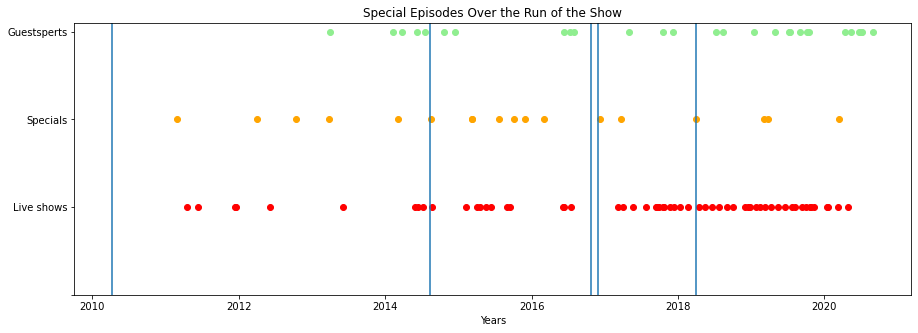

In [4]:
import matplotlib.pyplot as plt

data = [[]]*3
data[0] = [1 if i else np.nan for i in df["Live"]]
data[1] = [2 if i < 0 else np.nan for i in df["Ep_Num"]]
data[2] = [3 if type(i) == str else np.nan for i in df["Guestspert"]]
x = df["Date"]

fig, ax = plt.subplots(figsize=(15,5))
plt.plot(x, data[0], 'o', color='red')
plt.plot(x, data[1], 'o', color='orange')
plt.plot(x, data[2], 'o', color='lightgreen')
plt.yticks(np.arange(4), ["", "Live shows", "Specials", "Guestsperts"])
plt.xlabel("Years")
plt.title("Special Episodes Over the Run of the Show")

# First Episode of the show
plt.axvline(dt.strptime("04-12-2010", "%m-%d-%Y"))
# Justin's first kid
plt.axvline(dt.strptime("08-12-2014", "%m-%d-%Y"))
# Travis' first kid
plt.axvline(dt.strptime("10-25-2016", "%m-%d-%Y"))
# Griffin's first kid
plt.axvline(dt.strptime("11-25-2016", "%m-%d-%Y"))
# Margaritaville red carpet
plt.axvline(df[df["Ep_Num"]==400]["Date"])

plt.show()

Based on the graph above there is a noticeable increase in the number of live shows posted after all three brothers became fathers around the end of 2016, which makes sense because they would have had less time to record and edit their typical weekly shows, and depended more on posting older, previously recorded live shows.  
There is also an increase in the number of guestsperts invited to the show after their invitation to the red carpet event for Jimmy Buffett's Broadway debut of Escape to Margaritaville, which brought them in contact with Marilu Henner, who later featured as a guestspert in episode 414.

### Episode Details and Transcripts

To get more details, I compiled a list of links to each episode page in order to access the episode descriptions. Any missing links were manually added. The episode descriptions and suggested talking points give us a better idea of the topics covered in each episode.

In [5]:
combined = pre_era + max_fun
links = []
script_links = [np.nan for i in range(len(df))]
count = -1

combined = [i for i in combined.split("<") if len(i) > 30]
for l in combined:
    if "href" in l:
        link = l.split("\"")[1].split("\"")[0]
        
        # obtain the correct episode page links
        to_add = " " not in link and "Transcript" not in link 
        to_add = to_add and "Rachel" not in link 
        to_add = to_add and "Teresa" not in link 
        to_add = to_add and "Travis_M" not in link
        
        if to_add:
            links.append(link)
            count += 1
            
    if "Full Transcript" in l:
        script = l.split("href=\"")[1].split("\"")[0]
        if "dropbox" not in script:
            script_links[count] = script

# going through links to see if any need to be manually entered
for i in range(len(links)):
    if "mw" in links[i]:
        print(str(i) + ": " + df["Title"][i])

158: Face 2 Face 6: MaxFunCon2013
218: MBMBaM: The Adventure Zone
252: Bro's Better, Bro's Best: Ch. 62- 71


In [6]:
links[158] = "/wiki/Episode_155:_Face_2_Face_6:_MaxFunCon_2013"
links[218] = "/wiki/Adventure_Zone"
links[252] = "/wiki/Episode_245:_Bro%27s_Better,_Bro%27s_Best:_Ch._62-_71"

Now that we have the links to each episode page, we can start adding episode descriptions. The Suggested Talking Points can give us a better idea of the topics covered in each episode, although they don't exist for live shows. The two extra-special episodes, the Adventure Zone pilot and the Big Gulp MaxFun donor special, are manually added since they don't fit the typical episode format.

In [7]:
descriptions = []
talk_pts = []

for i, r in df.iterrows():
    
    req = requests.get(url+links[i], headers=headers)
    small_soup = BeautifulSoup(req.text, features="html.parser")
    
    # 'The Adventure Zone' also functions as the pilot to their 
    # DnD spinoff podcast of the same name
    if "Adventure Zone" in r["Title"]:
        descriptions.append("Episode 1 of The Adventure Zone.")
        talk_pts.append(np.nan)
        continue
    
    # 'The Big Gulp' is a donor special, supposedly the 36th
    # episode of a different podcast that does not exist
    if "Big Gulp" in r["Title"]:
        big_gulp = "Episode 36 of Big Gulp, a fictional vore-themed "
        big_gulp += "podcast hosted by Griffin and Travis McElroy."
        descriptions.append(big_gulp)
        talk_pts.append(np.nan)
        continue
    
    split_soup = small_soup.text.replace("[edit | edit source]", "")
    split_soup = split_soup.split("Description")
    
    d_id = len(split_soup) - 1
    ep_desc = split_soup[d_id]
    ep_desc = ep_desc.split("\n")
    ep_desc = [i for i in ep_desc if i]
    
    descriptions.append(ep_desc[0])
    
    if "Suggested" in ep_desc[1]:
        if "Outline" in ep_desc[2]:
            talk_pts.append(ep_desc[1].split(": ")[1])
        else:
            talk_pts.append(ep_desc[2])
    else:
        talk_pts.append(np.nan)
        
df["Ep_Desc"] = descriptions
df["Sugg_Talking_Pts"] = talk_pts

For a more complete list of transcripts, official transcripts of the show can be found on the Maximum Fun website for episodes 384 to 528. Since some of the linked transcripts of the Wiki page are more difficult to process, we are using the official transcripts.

In [8]:
prev = "https://maximumfun.org/transcripts/my-brother-my-brother-and-me"
prev += "/transcript-mbmbam-528-the-war-with-grandpa-watch/"

while(len(prev) > 0):
    r_script = requests.get(prev, headers=headers)
    scroup = BeautifulSoup(r_script.text, features="html.parser")
    
    title = str(scroup.find("title")).split(">")[1].split("<")[0]
    match = re.search(r"\d\d\d", title)
    if match:
        ep_num = int(match[0])
    elif "Single Sleeved" in title:
        ep_num = 498
    else:
        ep_num = -10
    
    cold_soup = str(scroup)
    if ep_num > 0 and "download\" href" in cold_soup:
        index = df.index[df["Ep_Num"]==ep_num][0]
        script_link = cold_soup.split("download\" href")[1].split("\"")[1]
        if type(script_links[index]) == float:
            script_links[index] = script_link
    
    if ep_num == 384:
        break
    if "transcript-previous" in str(scroup):
        prev = str(scroup).split("\"transcript-previous\">")[1]
        prev = prev.split("\"")[1]

### Ten Episode Analysis

Now that we have a complete list of episode descriptions and available transcripts, we can begin to analyze the contents of the episodes. Since there are so many episodes, we will be looking at a smaller sample of ten episodes. The sample was selected to have transcripts available so that we can analyze them as well.

In [9]:
sample = df[df["Script_Avail"]==True].sample(10)
sample

,Ep_Num,Title,Date,Script_Avail,Live,Guestspert,Ep_Desc,Sugg_Talking_Pts
16,17,"Just the Stats, Fats",2010-08-09 00:00:00,True,False,NaN,This week's episode is brought to you in stunn...,"The mane event, a touch of slavery, stalker/st..."
245,240,Teen Google,2015-02-23 00:00:00,True,False,NaN,"We hope you've enjoyed our podcast, because du...","All Movie Watch, Garbage Corn, Oscar Dogs, Nic..."
401,388,Face 2 Face: The Mystery of the Seven Parrots,2018-01-10 00:00:00,True,True,NaN,Pretty much everyone in our family is sick thi...,NaN
535,519,The Grandma Tesseract,2020-07-20 00:00:00,True,False,NaN,"The stakes are awfully high this episode, both...","Mr. Reggie Bigshot, One Chance Trick Shorts, K..."
381,368,The Sun Shines On Our Dark Planet!,2017-08-21 00:00:00,True,False,NaN,"Justin, Travis and Dane are back again to talk...",NaN
421,407,Morton Shart's Joke School,2018-05-21 00:00:00,True,False,NaN,"In this episode, Justin reveals to the rest of...","A Georgia-Fried Prawnline, Saddle Bag Spanking..."
521,505,Slippery When Voltron,2020-04-06 00:00:00,True,False,NaN,"In today’s episode, we set a new record for La...","Hot Gin, Sonic’s Sacrifice, Timesheet Secrets,..."
32,33,Bramblepelt,2010-12-06 00:00:00,True,False,NaN,"As the temperature drops, your physiological n...","Creepin', The Even Longer Con, On the DL, Dail..."
498,483,Face 2 Face: Beemen,2019-10-28 00:00:00,True,True,NaN,We’re taking a sick week and tossing up anothe...,NaN
266,259,Birthday Surprise Hole,2015-07-06 00:00:00,True,False,NaN,"So, look. Here's the thing. We prepped all our...","Cold Showers, Exotic Salsas, Video Toasters, M..."


In [10]:
for i, r in sample.iterrows():
    print(r["Sugg_Talking_Pts"])

The mane event, a touch of slavery, stalker/stalkee, embraces, algebra follies, Bs before Hs, The Biggest Loser, a PSA
All Movie Watch, Garbage Corn, Oscar Dogs, Nick Cannon-Lodeon, Salmon Burgers, Sir James Brewer: Defender of the Realm, Business Palantir, Ruth Orbs
nan
Mr. Reggie Bigshot, One Chance Trick Shorts, Knife Improvements, An Intolerable Bitcoin Segment, Creamy Creamz, Mall Jobs
nan
A Georgia-Fried Prawnline, Saddle Bag Spanking, Guy Club, Bathroom Friendship Window, The Worst Money Zone Transition in the History of Earth, The Sitting Tree, Einstein's Bones
Hot Gin, Sonic’s Sacrifice, Timesheet Secrets, Bathroom Investigations, Goldfish Punishment, Large Old Pizza News, Titanic Kaiju
Creepin', The Even Longer Con, On the DL, Daily Penis Briefing, Have Mercy, Methspresso, A Bad Scene, Troutleap, Friendtimacy
nan
Cold Showers, Exotic Salsas, Video Toasters, Minkus Khan, Safety Patrol, The Pub, Vintage Cocaine, Balls Out United, Peer-Reviewed Bacon, Credit Card Collapse, On Fr

In [23]:
import io
from PyPDF2 import PdfFileReader

grif = "Griffin:"
trav = "Travis:"
jus = "Justin:"

griff_speaks = [0]*10
trav_speaks = [0]*10
juice_speaks = [0]*10

ep_count = 0

for i,r in sample.iterrows():
    index = df.index[df["Ep_Num"]==r["Ep_Num"]][0]
    
    pdf_url = script_links[index]
    r = requests.get(pdf_url)
    
    if "fun.org" in pdf_url:
        f = io.BytesIO(r.content)
        reader = PdfFileReader(f)
        
        for i in range(reader.getNumPages()):
            contents = reader.getPage(i).extractText()
            contents = contents.replace("\n", "")
            
            griff_speaks[ep_count] += contents.count(grif)
            trav_speaks[ep_count] += contents.count(trav)
            juice_speaks[ep_count] += contents.count(jus)
    else:
        souped = BeautifulSoup(r.text, features="html.parser")
        contents = souped.text
        
        griff_speaks[ep_count] += contents.count(grif)
        trav_speaks[ep_count] += contents.count(trav)
        juice_speaks[ep_count] += contents.count(jus)
    
    ep_count += 1


In [22]:
total = []
grif_perc = []
trav_perc = []
jus_perc = []

for i in range(10):
    count = griff_speaks[i]+trav_speaks[i]+juice_speaks[i]
    total.append(count)
    grif_perc.append(griff_speaks[i]/count)
    trav_perc.append(trav_speaks[i]/count)
    jus_perc.append(juice_speaks[i]/count)

mini_data = {'Ep_Num': sample["Ep_Num"], 'Date': sample["Date"], 'Total': total, 
             'Griffin%': grif_perc, 'Travis%': trav_perc, 'Justin%': jus_perc}
mini_df = pd.DataFrame(data=mini_data)
mini_df

,Ep_Num,Date,Total,Griffin%,Travis%,Justin%
16,17,2010-08-09 00:00:00,497,0.340040,0.265594,0.394366
245,240,2015-02-23 00:00:00,588,0.386054,0.324830,0.289116
401,388,2018-01-10 00:00:00,916,0.318777,0.348253,0.332969
535,519,2020-07-20 00:00:00,798,0.312030,0.339599,0.348371
381,368,2017-08-21 00:00:00,561,0.360071,0.338681,0.301248
421,407,2018-05-21 00:00:00,727,0.327373,0.321871,0.350757
521,505,2020-04-06 00:00:00,646,0.325077,0.379257,0.295666
32,33,2010-12-06 00:00:00,564,0.343972,0.285461,0.370567
498,483,2019-10-28 00:00:00,793,0.350567,0.350567,0.298865
266,259,2015-07-06 00:00:00,845,0.351479,0.301775,0.346746


In [15]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,7))

# seaborn violin plot
# life expectancy across the years
g = sns.violinplot(
    data=mini_df,
    x="Date", y="lifeExp",
)

plt.title("Life expectancy across time")

plt.show()

SyntaxError: invalid syntax (<ipython-input-15-8690708c54d2>, line 1)